In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import numpy as np

# Dataset and Setup

In [2]:

# Define categorical columns
categoral_columns = [
    "workclass",
    "education",
    "marital.status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native.country",
    "income"
]

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)

    # Keep only required categorical columns
    df = df[categoral_columns]

    # Treat "?" as its own category
    df.replace("?", "Missing", inplace=True)

    # Encode categories as integers
    for col in categoral_columns:
        df[col] = df[col].astype("category").cat.codes

    # Split X and y
    X = df.drop("income", axis=1)
    y = df["income"]

    # 70% training, 30% validation + test
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, random_state=42, stratify=y
    )

    # Split 15% validation, 15% test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


### Analyze class distributions and feature-target relationships

In [3]:
# Analyze class distributions and feature-target relationships
def analyze_data(X, y):
    print("Class distribution:")
    print(y.value_counts(normalize=True))

    for col in X.columns:
        print(f"\nFeature: {col}")
        feature_target_dist = pd.crosstab(X[col], y, normalize='index')
        print(feature_target_dist)

# Naïve Bayes Implementation

## Train Naive Bayes model

In [4]:

# Train Naive Bayes model
def train_naive_bayes(X_train, y_train, alpha=1):
    class_priors = {}
    feature_likelihoods = {}

    classes = y_train.unique()
    num_classes = len(classes)
    total_samples = len(y_train)

    # CLASS PRIORS
    for cls in classes:
        count_cls = (y_train == cls).sum()
        class_priors[cls] = (count_cls + alpha) / (total_samples + alpha * num_classes)

    # FEATURE LIKELIHOODS
        # Get all samples of class cls
        X_cls = X_train[y_train == cls]
        feature_likelihoods[cls] = {}

        for col in X_train.columns:
            # Get unique values of the feature
            feature_values = X_train[col].unique()
            total_count = len(X_cls)
            num_feature_values = len(feature_values)

            likelihoods = {}

            for feature_value in feature_values:
                # Count of feature_value in class cls
                count_value = (X_cls[col] == feature_value).sum()

                likelihoods[feature_value] = (count_value + alpha) / (
                    total_count + alpha * num_feature_values
                )

            feature_likelihoods[cls][col] = likelihoods
    return class_priors, feature_likelihoods

## Prediction

### probability predictions helper functions

In [5]:
# probability predictions helper functions
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def log_probs_to_probs(log_probs):
    classes = list(log_probs.keys())
    log_values = np.array([log_probs[c] for c in classes])
    probs = softmax(log_values)
    return dict(zip(classes, probs))

### Predict using log probabilities

In [6]:
# Predict using log probabilities
# Probability Analysis: Examine predicted probabilities distribution
def predict_single_log(x, class_priors, feature_likelihoods):
    best_class = None
    best_log_prob = -float("inf")
    log_probs = {}
    for cls in class_priors:
        # Start with log prior
        log_prob = math.log(class_priors[cls])
        # Add log likelihoods
        for col, _ in x.items():
            likelihood = feature_likelihoods[cls][col].get(x[col], 1e-8)  # Smoothing for unseen feature values
            log_prob += math.log(likelihood)
            log_probs[cls] = log_prob
        # Choose class with max log probability
        if log_prob > best_log_prob:
            best_log_prob = log_prob
            best_class = cls

    probs = log_probs_to_probs(log_probs)
    return best_class, probs

def predict_log(X, class_priors, feature_likelihoods):
    preds = []
    log_probs_list = []
    for _, row in X.iterrows():
        single_log_pred, log_probs = predict_single_log(row, class_priors, feature_likelihoods)
        preds.append(single_log_pred)
        log_probs_list.append(log_probs)
    return preds, log_probs_list

# Evaluate Accuracy

In [7]:
def evaluate_accuracy(y_true, y_pred):
    correct = sum(y_true == y_pred)
    return correct / len(y_true)

# Validations and Hyperparameters tuning

## Alpha tuning

In [8]:
def validate_alpha(X_val, y_val, X_train, y_train, alphas = [0.1, 0.5, 1.0, 2.0, 5.0]):
    best_alpha = None
    best_accuracy = 0
    accuracy_list = []
    for alpha in alphas:
        class_priors, feature_likelihoods = train_naive_bayes(X_train, y_train, alpha)
        y_val_pred, _ = predict_log(X_val, class_priors, feature_likelihoods)
        accuracy = evaluate_accuracy(y_val, y_val_pred)
        accuracy_list.append(accuracy)
        print(f"Alpha: {alpha}, Validation Accuracy: {accuracy}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_alpha = alpha

    return best_alpha, accuracy_list

## Analyze impact of different feature subsets

In [19]:
# Feature Selection: Analyze impact of different feature subsets
def feature_selection_analysis(X_train, y_train, X_val, y_val, feature_subsets, alpha):
    validation_results_for_subsets = {}
    for subset in feature_subsets:
        X_train_subset = X_train[subset]
        X_val_subset = X_val[subset]

        class_priors, feature_likelihoods = train_naive_bayes(X_train_subset, y_train, alpha)
        y_val_pred, _ = predict_log(X_val_subset, class_priors, feature_likelihoods)
        accuracy = evaluate_accuracy(y_val, y_val_pred)
        validation_results_for_subsets[tuple(subset)] = accuracy
        print(f"Features: {subset}, Validation Accuracy: {accuracy}")

    return validation_results_for_subsets

# Multinomial Naive Bayes model

In [10]:
from sklearn.naive_bayes import MultinomialNB
# Train Multinomial Naive Bayes model
def train_multinomial_nb(X_train, y_train, alpha=1.0):
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train, y_train)
    return model

# Predict using Multinomial Naive Bayes model
def predict_multinomial_nb(model, X):
    return model.predict(X), model.predict_proba(X)

---------------------------------------------------------

# Analysis and Evalutation

## Dataset Analyis

In [32]:
X_train, X_val, X_test, y_train, y_val, y_test = load_and_preprocess_data("datasets/adult.csv")

In [33]:
analyze_data(X_train, y_train)

Class distribution:
income
0    0.75917
1    0.24083
Name: proportion, dtype: float64

Feature: workclass
income            0         1
workclass                    
0          0.600601  0.399399
1          0.710331  0.289669
2          0.891892  0.108108
3          1.000000  0.000000
4          0.780042  0.219958
5          0.460177  0.539823
6          0.721376  0.278624
7          0.732318  0.267682
8          1.000000  0.000000

Feature: education
income            0         1
education                    
0          0.933948  0.066052
1          0.948052  0.051948
2          0.911263  0.088737
3          0.958333  0.041667
4          0.957627  0.042373
5          0.950108  0.049892
6          0.944598  0.055402
7          0.747700  0.252300
8          0.731481  0.268519
9          0.588047  0.411953
10         0.241259  0.758741
11         0.839918  0.160082
12         0.454023  0.545977
13         1.000000  0.000000
14         0.270000  0.730000
15         0.808101  0.191899

Fea

## Training and predection

In [34]:
class_priors, feature_likelihoods = train_naive_bayes(X_train, y_train, alpha=0.1)

In [35]:
preds, log_probs_list = predict_log(X_test, class_priors, feature_likelihoods)

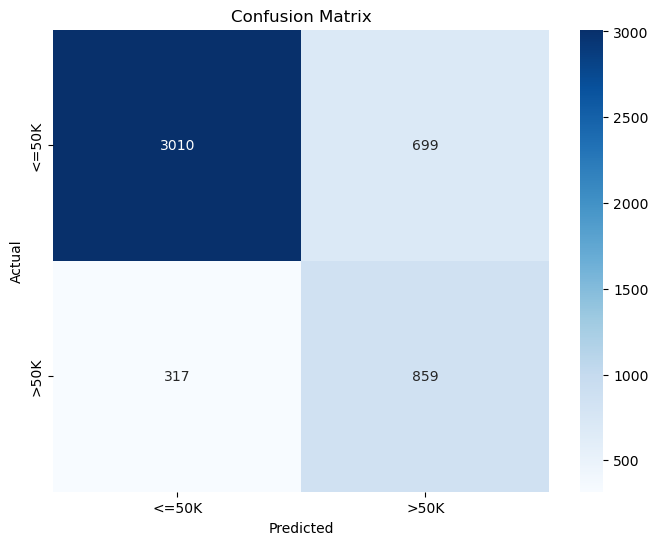

In [36]:
def plot_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, preds, classes=["<=50K", ">50K"])

## Plot distribution of the predicted probability for class <50K

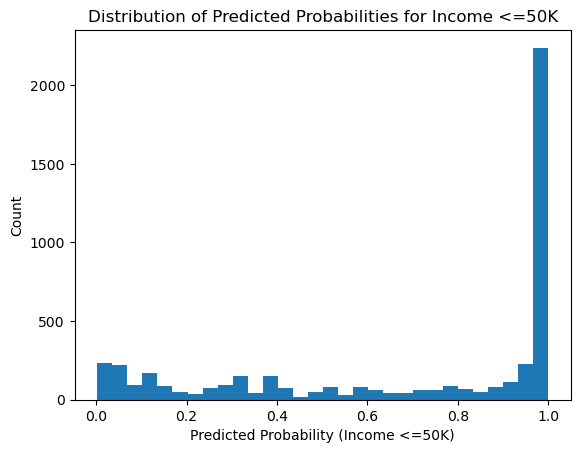

In [37]:
import matplotlib.pyplot as plt

probs_0 = [p[0] for p in log_probs_list]  # class "0" means <=50K

plt.hist(probs_0, bins=30)
plt.xlabel("Predicted Probability (Income <=50K)")
plt.ylabel("Count")
plt.title("Distribution of Predicted Probabilities for Income <=50K")
plt.show()




## Smoothing Parameter: Test α values [0.1, 0.5, 1.0, 2.0, 5.0]

Alpha: 0.1, Validation Accuracy: 0.7893120393120393
Alpha: 0.5, Validation Accuracy: 0.7891072891072891
Alpha: 1.0, Validation Accuracy: 0.7889025389025389
Alpha: 2.0, Validation Accuracy: 0.7889025389025389
Alpha: 5.0, Validation Accuracy: 0.7884930384930385
Best alpha: 0.1
Accuracy list: [0.7893120393120393, 0.7891072891072891, 0.7889025389025389, 0.7889025389025389, 0.7884930384930385]


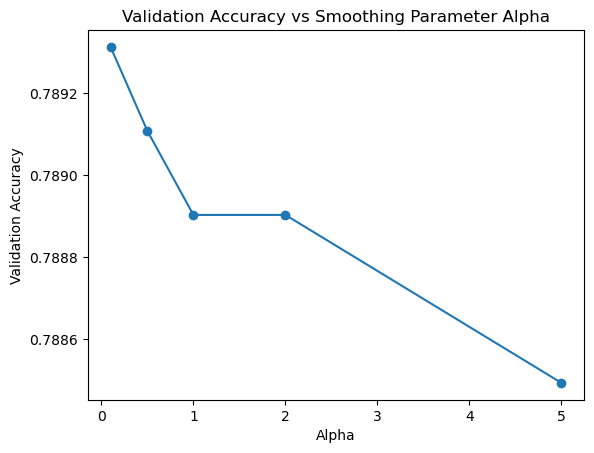

In [38]:
# Smoothing Parameter: Test α values [0.1, 0.5, 1.0, 2.0, 5.0]

best_alpha, accuracy_list = validate_alpha(X_val, y_val, X_train, y_train, alphas=[0.1, 0.5, 1.0, 2.0, 5.0])
print(f"Best alpha: {best_alpha}")
print(f"Accuracy list: {accuracy_list}")

# plot accuracy for different alphas
alphas = [0.1, 0.5, 1.0, 2.0, 5.0]
plt.plot(alphas, accuracy_list, marker='o')
plt.xlabel("Alpha")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Smoothing Parameter Alpha")
plt.show()


Accuracy decreases as α increases

This trend is typical for Naive Bayes:

Smaller α → model relies more on the true counts

Larger α → heavier smoothing → probabilities become more "blurry" → accuracy often drops slightly

accuracy drop is very small (~0.0008), which is completely reasonable.

## Feature Selection: Analyze impact of different feature subsets

Features: ['education', 'occupation'], Validation Accuracy: 0.7753890253890254
Features: ['marital.status', 'relationship'], Validation Accuracy: 0.7174447174447175
Features: ['workclass', 'occupation'], Validation Accuracy: 0.7606470106470107
Features: ['race', 'sex'], Validation Accuracy: 0.7592137592137592
Features: ['education', 'workclass'], Validation Accuracy: 0.7923832923832924
Features: ['native.country', 'education'], Validation Accuracy: 0.7835790335790336
Features: ['relationship', 'occupation'], Validation Accuracy: 0.8118345618345618
Features: ['marital.status', 'race'], Validation Accuracy: 0.7592137592137592
Features: ['sex', 'occupation'], Validation Accuracy: 0.785012285012285
Features: ['workclass', 'race'], Validation Accuracy: 0.7682227682227682
Features: ['education', 'occupation', 'workclass'], Validation Accuracy: 0.7823505323505323
Features: ['marital.status', 'relationship', 'race'], Validation Accuracy: 0.7266584766584766
Features: ['education', 'occupation',

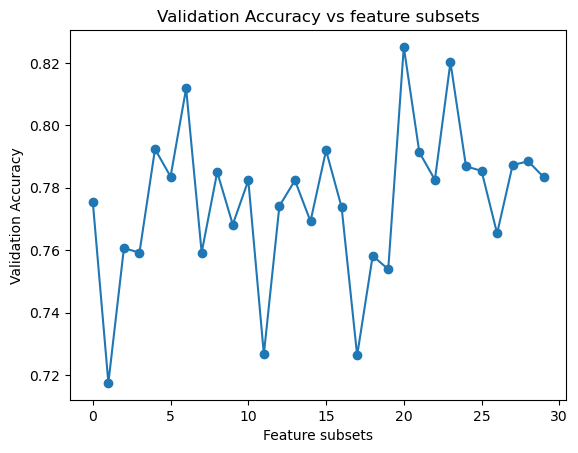

In [39]:
# Feature Selection: Analyze impact of different feature subsets

    # "workclass",
    # "education",
    # "marital.status",
    # "occupation",
    # "relationship",
    # "race",
    # "sex",
    # "native.country",
    # "income"

feature_subsets = [
    # Small subsets (2 features)
    ["education", "occupation"],
    ["marital.status", "relationship"],
    ["workclass", "occupation"],
    ["race", "sex"],
    ["education", "workclass"],
    ["native.country", "education"],
    ["relationship", "occupation"],
    ["marital.status", "race"],
    ["sex", "occupation"],
    ["workclass", "race"],

    # Medium subsets (3 features)
    ["education", "occupation", "workclass"],
    ["marital.status", "relationship", "race"],
    ["education", "occupation", "race"],
    ["workclass", "education", "occupation"],
    ["marital.status", "relationship", "occupation"],
    ["sex", "education", "occupation"],
    ["native.country", "education", "occupation"],
    ["workclass", "marital.status", "relationship"],
    ["race", "sex", "native.country"],
    ["education", "marital.status", "relationship"],

    # Medium-large subsets (4–5 features)
    ["education", "occupation", "workclass", "marital.status"],
    ["education", "occupation", "workclass", "marital.status", "relationship"],
    ["education", "occupation", "workclass", "race"],
    ["workclass", "occupation", "education", "relationship"],
    ["race", "sex", "native.country", "occupation"],
    ["marital.status", "relationship", "education", "occupation"],
    ["workclass", "occupation", "marital.status", "relationship", "race"],
    ["education", "occupation", "workclass", "marital.status", "relationship", "race"],
    ["education", "occupation", "marital.status", "relationship", "sex"],
    ["workclass", "education", "occupation", "race", "native.country"]
]


validation_results_for_subsets = feature_selection_analysis(X_train, y_train, X_val, y_val, feature_subsets, alpha=best_alpha)

# plot accuracy for different feature subsets
subset_labels = [index for index, subset in enumerate(feature_subsets)]
accuracy_values = [validation_results_for_subsets[tuple(subset)] for subset in feature_subsets]
plt.plot(subset_labels, accuracy_values, marker='o')
plt.xlabel("Feature subsets")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs feature subsets")
plt.show()

### What “correlated” means in general

Two features are correlated when knowing the value of one gives you information about the other.

If two features are positively correlated, when one is high, the other tends to be high.

If they are negatively correlated, when one is high, the other tends to be low.

If they are uncorrelated, knowing one tells you nothing about the other.

### How to detect correlated features

Look at subsets where accuracy does not improve much when adding a feature → likely correlated with existing features

Look at subsets where accuracy is low when only the correlated features are used → they don’t add independent info

Example from results:

marital.status + relationship → accuracy 0.717

Individually these features overlap information → correlated → low predictive power

education + occupation → 0.775

Some correlation exists, but combining them gives more info → higher accuracy

### Why correlation matters for Naive Bayes

Naive Bayes assumes feature independence: each feature contributes independently to the probability of the target.

If two features are correlated, the model “double counts” the information: it thinks it’s seeing independent evidence twice.

This can lead to:

Slightly inflated probabilities

Sometimes lower accuracy

In [40]:
# helper function to get worst feature subsets
def get_worst_feature_subsets(validation_results, n=5):
    # Sort subsets by accuracy
    sorted_subsets = sorted(validation_results.items(), key=lambda item: item[1])
    # Get worst n subsets
    worst_subsets = sorted_subsets[:n]
    return worst_subsets

worst_subsets = get_worst_feature_subsets(validation_results_for_subsets, n=7)
print("Worst 7 feature subsets:")
for subset, accuracy in worst_subsets:
    print(f"Subset: {subset}, Accuracy: {accuracy:.4f}")

Worst 7 feature subsets:
Subset: ('marital.status', 'relationship'), Accuracy: 0.7174
Subset: ('workclass', 'marital.status', 'relationship'), Accuracy: 0.7262
Subset: ('marital.status', 'relationship', 'race'), Accuracy: 0.7267
Subset: ('education', 'marital.status', 'relationship'), Accuracy: 0.7539
Subset: ('race', 'sex', 'native.country'), Accuracy: 0.7582
Subset: ('race', 'sex'), Accuracy: 0.7592
Subset: ('marital.status', 'race'), Accuracy: 0.7592


| Feature subset                                | Why they are correlated / low predictive power                                                                                       |
| --------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------ |
| `marital.status` & `relationship`             | People with `Married-civ-spouse` usually have `relationship` = `Husband` or `Wife`; features overlap information.                    |
| `workclass`, `marital.status`, `relationship` | `marital.status` and `relationship` are correlated; `workclass` adds little independent info here.                                   |
| `marital.status`, `relationship`, `race`      | Same as above; `race` is mostly independent, but the first two dominate the info → correlated features reduce NB performance.        |
| `education`, `marital.status`, `relationship` | `marital.status` & `relationship` correlated; adding `education` helps slightly, but overlapping features limit gain.                |
| `race`, `sex`, `native.country`               | Slight correlations exist (dataset biases), e.g., some nationalities more likely male/female or certain races; low predictive power. |
| `race` & `sex`                                | Demographic bias causes weak correlation; together they provide little independent information.                                      |
| `marital.status` & `race`                     | Some minor correlations in dataset, but generally not strong predictors for income → low accuracy.                                   |


## Independence Assumption: Discuss violations and their impact

### Independence Assumption in Naive Bayes

Naive Bayes makes a strong assumption:

> All features are conditionally independent given the target class.

Mathematically, for features `x_1, x_2, ..., x_n` and class `C`:

$$
P(x_1, x_2, \dots, x_n \mid C) = \prod_{i=1}^{n} P(x_i \mid C)
$$

This assumption simplifies probability calculations and makes the algorithm very fast and memory-efficient.


### Violations and Impact

In real-world datasets, features are often correlated:

- **Example 1:** `marital.status` and `relationship`  
  If someone is `Married-civ-spouse`, their `relationship` is likely `Husband` or `Wife`.

- **Example 2:** `education` and `occupation`  
  Certain jobs require certain education levels, so these features are partially dependent.

**Impact of violating independence:**

1. **Double-counting information** – correlated features can inflate probabilities.  
2. **Reduced predictive performance** – subsets with correlated features may have lower accuracy.  
3. **Overconfident probabilities** – the predicted probabilities may be misleading.  

**Mitigation:**  
- Remove highly correlated features.  
- Use feature selection to keep mostly independent features.  
- Consider more advanced models if correlations are strong.


## Performance Comparison: Compare with sklearn's MultinomialNB

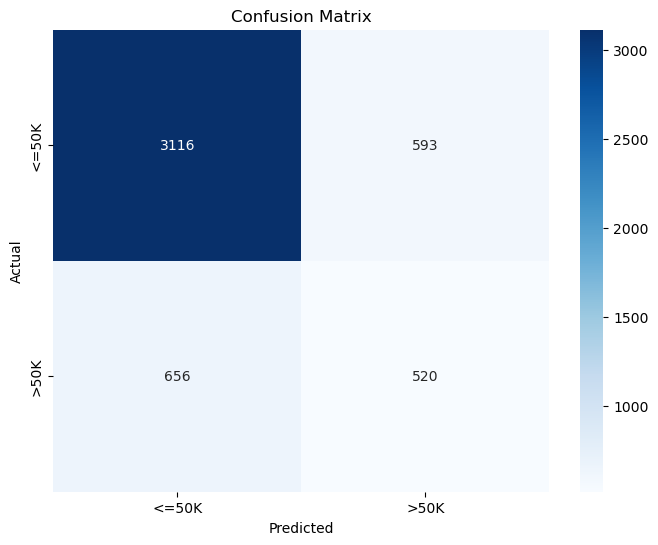

Multinomial Naive Bayes Test Accuracy: 0.7443193449334699
Custom Naive Bayes Test Accuracy: 0.7920163766632549


In [42]:
# Evaluate Multinomial Naive Bayes
mnnb_model = train_multinomial_nb(X_train, y_train, alpha=best_alpha)
mnnb_preds, mnnb_probs = predict_multinomial_nb(mnnb_model, X_test)

plot_confusion_matrix(y_test, mnnb_preds, classes=["<=50K", ">50K"])

# compare accuracy with custom Naive Bayes
mnnb_accuracy = evaluate_accuracy(y_test, mnnb_preds)
print(f"Multinomial Naive Bayes Test Accuracy: {mnnb_accuracy}")
print(f"Custom Naive Bayes Test Accuracy: {evaluate_accuracy(y_test, preds)}")